In [1]:
import pandas as pd
import mplfinance as mpf
from regime_detection import get_msm, identify_bull_bear_states, get_transition_counts
import numpy as np
from deeptime import markov
from utils import generate_ar_weights, indicator_signal
import random
import matplotlib.pyplot as plt
from trend import generate_signals, get_action_dates, plot_actions

In [2]:
random.seed(42)

In [3]:
symbol = 'GESHIP'
df = pd.read_csv(f'../data/symbols/{symbol}.csv')
data = df[['date', 'returns']]
data['returns'] = data['returns']
data.describe()

C:\Users\adity\AppData\Local\Temp\ipykernel_22136\2112785641.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['returns'] = data['returns']


,returns
count,126.000000
mean,0.012499
std,0.091314
min,-0.205554
25%,-0.047212
50%,0.014085
75%,0.069800
max,0.305335


In [4]:
split = 0.7
train_data, test_data = data[:int(split*len(data))], data[int(split*len(data)):]
test_data = test_data.reset_index(drop=True)

<Axes: >

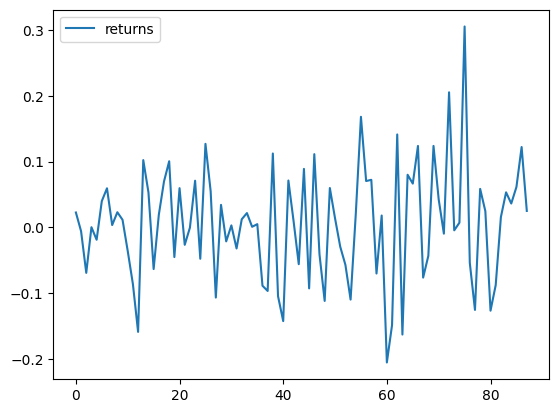

In [5]:
train_data.plot()

(array([ 3.,  8., 12., 13., 24., 17.,  8.,  1.,  1.,  1.]),
 array([-0.20555373, -0.15446485, -0.10337598, -0.0522871 , -0.00119823,
         0.04989065,  0.10097952,  0.1520684 ,  0.20315728,  0.25424615,
         0.30533503]),
 <BarContainer object of 10 artists>)

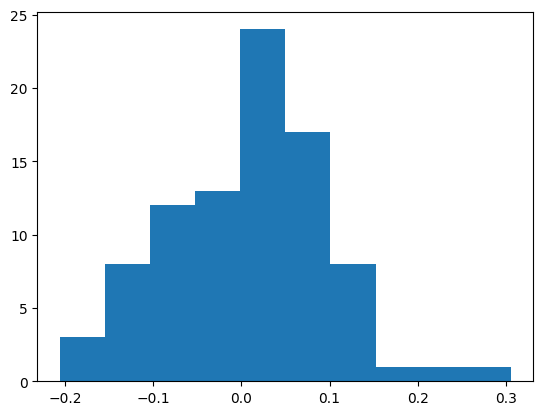

In [6]:
plt.hist(train_data['returns'])

In [7]:
train_asset_states, train_stats = identify_bull_bear_states(train_data)

9 88


c:\Users\adity\markov-switching-model-trading\src\regime_detection.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cumulative returns'] = (1 + df['returns']).cumprod() - 1
c:\Users\adity\markov-switching-model-trading\src\regime_detection.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['State'] = states
c:\Users\adity\markov-switching-model-trading\src\regime_detection.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [8]:
train_asset_states

,date,returns,Cumulative returns,State,Turning Point
0,2015-02-01 00:00:00+05:30,0.022506,0.022506,0,True
1,2015-03-01 00:00:00+05:30,-0.005978,0.016393,0,False
2,2015-04-01 00:00:00+05:30,-0.069300,-0.054043,0,False
3,2015-05-01 00:00:00+05:30,0.000147,-0.053904,0,False
4,2015-06-01 00:00:00+05:30,-0.018943,-0.071826,0,False
...,...,...,...,...,...
83,2022-01-01 00:00:00+05:30,0.053152,-0.127396,1,False
84,2022-02-01 00:00:00+05:30,0.036141,-0.095860,1,False
85,2022-03-01 00:00:00+05:30,0.061309,-0.040428,1,False
86,2022-04-01 00:00:00+05:30,0.122050,0.076688,0,True


In [9]:
train_stats

,State,mean,std
0,0,0.017068,0.077051
1,1,-0.006759,0.096021


In [10]:
mu_a, mu_b = train_stats.loc[0, 'mean'], train_stats.loc[1, 'mean']
sigma_a, sigma_b = train_stats.loc[0, 'std'], train_stats.loc[1, 'std']

In [11]:
test_data

,date,returns
0,2022-06-01 00:00:00+05:30,-0.003903
1,2022-07-01 00:00:00+05:30,0.198686
2,2022-08-01 00:00:00+05:30,0.201286
3,2022-09-01 00:00:00+05:30,-0.051260
4,2022-10-01 00:00:00+05:30,0.030900
5,2022-11-01 00:00:00+05:30,0.191151
6,2022-12-01 00:00:00+05:30,0.010924
7,2023-01-01 00:00:00+05:30,-0.043747
8,2023-02-01 00:00:00+05:30,-0.140831
9,2023-03-01 00:00:00+05:30,0.169358


In [12]:
test_asset_states, test_stats = identify_bull_bear_states(test_data)

8 38


In [13]:
test_stats

,State,mean,std
0,0,0.053849,0.075990
1,1,-0.058793,0.125495


In [14]:
transition_counts, total = get_transition_counts(train_asset_states)
transition_counts

[[0.9047619047619048, 0.09523809523809523],
 [0.08888888888888889, 0.9111111111111111]]

In [15]:
estimator = markov.msm.MaximumLikelihoodMSM(
    reversible=True,
    stationary_distribution_constraint=None
)

true_msm = markov.msm.MarkovStateModel(transition_counts)
trajectory = true_msm.simulate(50000)
counts_estimator = markov.TransitionCountEstimator(
    lagtime=1, count_mode="sliding"
)
counts = counts_estimator.fit(trajectory).fetch_model()
counts


TransitionCountModel-2463917293088:[{'count_matrix': array([[21978.,  2244.],
                                          [ 2243., 23534.]]),
                                    'count_matrix_full': array([[21978.,  2244.],
                                          [ 2243., 23534.]]),
                                    'counting_mode': 'sliding',
                                    'lagtime': 1,
                                    'state_histogram': array([24222, 25778]),
                                    'state_histogram_full': array([24222, 25778]),
                                    'state_symbols': array([0, 1])}]

In [16]:
regime_switching_model = estimator.fit(counts).fetch_model()
print("Estimated transition matrix:", regime_switching_model.transition_matrix)
print("Estimated stationary distribution:", regime_switching_model.stationary_distribution)

Estimated transition matrix: [[0.90735696 0.09264304]
 [0.08701556 0.91298444]]
Estimated stationary distribution: [0.48433841 0.51566159]


In [17]:
alpha, beta = regime_switching_model.transition_matrix[0][1], regime_switching_model.transition_matrix[1][0]

In [18]:
ar_weights = generate_ar_weights(alpha, beta, mu_a, mu_b, sigma_a, sigma_b, p=20)

pi_a =  0.48433840553406454
pi_b =  0.5156615944659355
sigma =  0.08815719485441753
c =  0.018245074131356672
phi =  0.8203413921381969
d =  1.0233774462348988


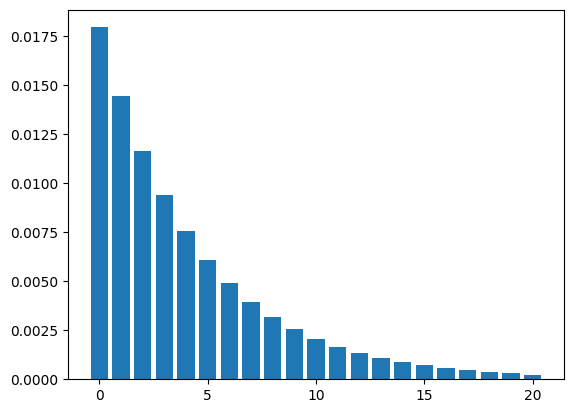

In [19]:
plt.figure()
plt.bar([i for i in range(0, len(ar_weights))], ar_weights)
plt.show()

In [20]:
np.save(f'../models/{symbol}', ar_weights)

In [21]:
signals = generate_signals(train_data, ar_weights)

In [22]:
def sma(returns, window):
    signals = []
    for i in range(len(returns)):
        if i < window:
            signals.append(0)  # Not enough data to calculate SMA
        else:
            current_sma = sum(returns[i-window:i]) / window
            prev_sma = sum(returns[i-window-1:i-1]) / window
            if current_sma > prev_sma:
                signals.append(current_sma)  # SMA rising
            elif current_sma < prev_sma:
                signals.append(current_sma)  # SMA falling
            else:
                signals.append(0)  # No change
    return signals

sma_sig = sma(np.asarray(train_data['returns'].reset_index(drop=True)), 4)

In [23]:
signals

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 np.float64(0.008880970986511177),
 np.float64(0.01571185655646881),
 np.float64(0.00881920568112207),
 np.float64(0.00716141740653862),
 np.float64(0.016004847212883717),
 np.float64(0.006017862488232786),
 np.float64(0.023109844783697944),
 np.float64(0.026446431398834836),
 np.float64(0.0058646052511727685),
 np.float64(0.009611234377229215),
 np.float64(0.0046288744374065535),
 np.float64(0.0042178451652722685),
 np.float64(-0.001091754132077073),
 np.float64(0.001187286230672848),
 np.float64(0.003886334430119716),
 np.float64(0.0031381891749134205),
 np.float64(0.0033391797740121693),
 np.float64(-0.01018662277604651),
 np.float64(-0.02233805270210097),
 np.float64(-0.0019789699874364214),
 np.float64(-0.016639116592137983),
 np.float64(-0.03413951162880588),
 np.float64(-0.017181709012515083),
 np.float64(-0.0124813326671893),
 np.float64(-0.018303548080361665)

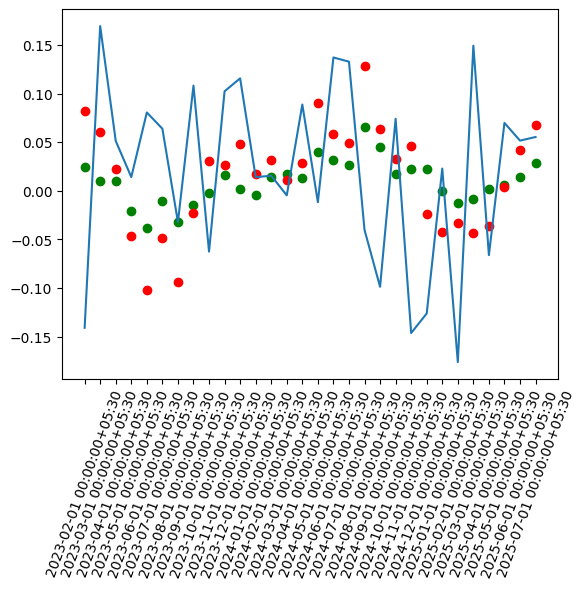

In [24]:
plt.figure()
plt.plot(data['date'][-30:], data['returns'][-30:])
plt.scatter(data['date'][-30:], signals[-30:], color='green')
plt.scatter(data['date'][-30:], sma_sig[-30:], color='red')
#plt.vlines(sell_dates[-30:], -0.05, 0.05, color='red')
plt.xticks(rotation=70)
plt.show()

In [25]:
buy_dates, sell_dates = get_action_dates(train_data, signals)


In [26]:
plot_actions(train_data, buy_dates, sell_dates, signals)

ConversionError: Failed to convert value(s) to axis units: masked_array(data=[--, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --],
             mask=[ True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True],
       fill_value=1e+20,
            dtype=float64)

<Figure size 640x480 with 1 Axes>

In [27]:
test_signals = generate_signals(test_data, ar_weights)

In [28]:
test_buy_dates, test_sell_dates = get_action_dates(test_data, test_signals)

ValueError: x and y must be the same size

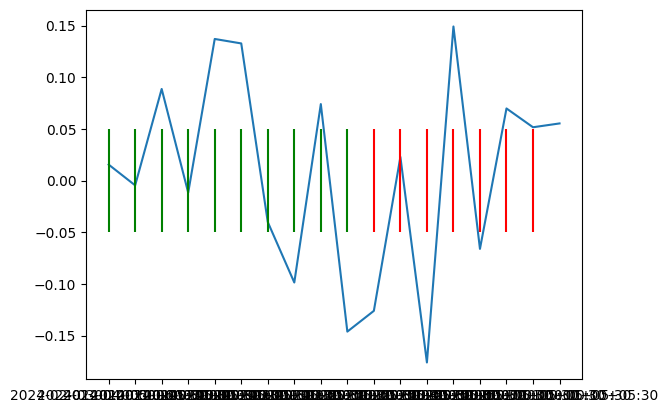

In [29]:
plot_actions(test_data, test_buy_dates, test_sell_dates, test_signals)